## **Regression by AutoGluon**

Google Colaboratory環境でのDiamondsデータセットの回帰実行サンプル


【公式】Predicting Columns in a Table - Quick Start  
https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-quickstart.html

【reference】AutoGluon Predictors  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit

【機械学習】AutoGluonの使い方・クイックスタートの解説(表形式データ) -  2021-06-17  
https://predora005.hatenablog.com/entry/2021/06/17/000000

#### **Google Colaboratoyの環境確認/設定**

In [1]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# AutoGluon
!pip install -U "folium==0.2.1"
!pip install -U "imgaug<0.2.7,>=0.2.5"
!pip install -U "mxnet_cu101<2.0.0"   # for GPU: CUDA 10.1 for coolge colaboratory
!pip install autogluon

Ubuntu 18.04.5 LTS \n \l

Linux c17f4f652b27 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
MemTotal: 25.4597 GB
MemFree: 22.6047 GB
MemAvailable: 24.5515 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
/dev/sda1       154G   41G  114G  27% /opt/bin/.nvidia
0.0979917 hours (352.77sec)
Sat Aug 28 17:42:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               | 

### **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # pythonバージョン: 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
print(f'now: {datetime.now(JST):"%F %T)}') 

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import sklearn 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# metrics for Classificaqtion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# metrics for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import autogluon as ag
from autogluon.tabular import TabularPredictor

import xgboost
import lightgbm
import catboost

#バージョン確認
print(sys.version)
print(f'Module\'s Version; ',
      f'\n sklearn: {sklearn.__version__}, numpy: {np.__version__}, pandas: {pd.__version__},',
      f'\n xgboost: {xgboost.__version__}, lightgbm: {lightgbm.__version__}, catboost: {catboost.__version__},',
      )

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: "2021-08-29 02:44:11)
3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Module's Version;  
 sklearn: 0.24.2, numpy: 1.19.5, pandas: 1.1.5, 
 xgboost: 1.4.2, lightgbm: 3.2.1, catboost: 0.25.1,


#### **自作関数**

In [3]:
### Functions =================================================================
def xdescribe(df, dsp=True, ret=False):   # pandas.describeメソッドの拡張 

    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Featur: Categories')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return

### Functions =================================================================
# 変数の分布を確認
def target_dist(df, target_colname):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[target_colname])
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}')
    skewness    = skew(df[target_colname].dropna())
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}, 歪度 = {skewness:.2f}')

    # plot the distribution
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(target_colname+' distribution')
    sns.distplot(df[target_colname], fit=norm)

    ax = fig.add_subplot(1, 2, 2)
    stats.probplot(df[target_colname], plot=plt) #Q-Q plot
    plt.show()

### **データの取得・確認**

#### **seabornに含まれているdiamondsデータセットを使用**

各変数の属性の確認  
目的変数の分布を確認


## Shape:(506, 14)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
CRIM,float64,0,504,506,3.6135,8.6015,0.0063,0.0820,0.2565,3.6771,88.9762
ZN,float64,0,26,506,11.3636,23.3225,0.0000,0.0000,0.0000,12.5000,100.0000
INDUS,float64,0,76,506,11.1368,6.8604,0.4600,5.1900,9.6900,18.1000,27.7400
CHAS,float64,0,2,506,0.0692,0.2540,0.0000,0.0000,0.0000,0.0000,1.0000
NOX,float64,0,81,506,0.5547,0.1159,0.3850,0.4490,0.5380,0.6240,0.8710
RM,float64,0,446,506,6.2846,0.7026,3.5610,5.8855,6.2085,6.6235,8.7800
AGE,float64,0,356,506,68.5749,28.1489,2.9000,45.0250,77.5000,94.0750,100.0000
DIS,float64,0,412,506,3.7950,2.1057,1.1296,2.1002,3.2074,5.1884,12.1265
RAD,float64,0,9,506,9.5494,8.7073,1.0000,4.0000,5.0000,24.0000,24.0000
TAX,float64,0,66,506,408.2372,168.5371,187.0000,279.0000,330.0000,666.0000,711.0000


Shapes: train:(404, 14), test:(102, 14)

## 目的変数の分布を確認

 平均 = 22.61, 分散 = 9.23

 平均 = 22.61, 分散 = 9.23, 歪度 = 1.02


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


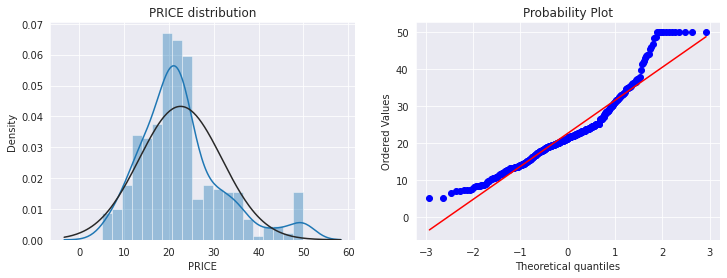

In [4]:
#ボストン住宅価格データセットの読み込み
from sklearn.datasets import load_boston
boston = load_boston()
# データフレームの作成
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = np.array(boston.target)
xdescribe(df)

target_colname = 'PRICE'          # 目的変数を指定

# データセットの分割 (学習用と学習後の評価用)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0, shuffle=True)
print(f'Shapes: train:{df_train.shape}, test:{df_test.shape}')

print(f'\n## 目的変数の分布を確認') 
target_dist(df_train, target_colname)

### **データセット、学習に関する設定 (setup)**

### **TabularPredictor**  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor
```
class autogluon.tabular.TabularPredictor（
    label、
    problem_type = None、 # Default=None = Auto  'binary', 'multiclass', 'regression', 'quantile’
    eval_metric = None、  # Default=None = Auto 
        # Classification: ['accuracy'、 'balanced_accuracy'、 
        #     'f1'、'f1_macro'、'f1_micro'、'f1_weighted'、'roc_auc'、 'roc_auc_ovo_macro'、
        #     'average_precision'、'precision'、'precision_macro'、 'precision_micro'、 ' Precision_weighted '、
        #     ' recall '、' recall_macro '、' recall_micro '、' recall_weighted '、
        #     ' log_loss '、' pac_score ']                          
        # Regression:  ['root_mean_squared_error'、 'mean_squared_error'、 'mean_absolute_error'、 
        #     'median_absolute_error'、 'r2']             
    path = None、
    verbosity = 2、
    sample_weight = None、
    weight_evaluation = False、
    groups = None、** kwargs
）
```
### **fit**  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit

```
fit(
    train_data, 
    tuning_data = None, 
    time_limit = None, 
    presets = None,   # default = [‘medium_quality_faster_train’] 
        # best_quality = {'auto_stack'：True}
        # high_quality_fast_inference_only_refit = {'auto_stack'：True、
        #     'refit_full'：True、'set_best_to_refit_full'：True '_ save_bag_folds'：False}
        # good_quality_faster_inference_only_refit = {'auto_stack'：True、
        #     'refit_full'：True、'set_best_to_refit_full'：True、 '_ save_bag_folds'：False、
        #     'hyperparameters'： 'light'}
        # medium_quality_faster_train = {'auto_stack'：False}
        # optimize_for_deployment = {'keep_only_best'：True、 'save_space'：True}
        # ignore_text = {'_ feature_generator_kwargs'：{'enable_text_ngram_features'：False、 
        #     'enable_text_special_features'：False、 'enable_raw_text_features'：False}}
    hyperparameters= None, #  ['default', 'light', 'very_light', 'toy', 'multimodal’]
    feature_metadata = 'infer', 
    **kwargs
)
```

### **学習の準備**

In [5]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here

### **学習1, ほぼデフォルト**

In [6]:
time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path).fit(df_train)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    26233.89 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:


## 2021-08-29 02:44:15


	0.6315	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist ...
	0.6914	 = Validation score   (r2)
	0.01s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT ...


[1000]	train_set's l2: 1.58374	train_set's r2: 0.9803	valid_set's l2: 7.55872	valid_set's r2: 0.907815


	0.9149	 = Validation score   (r2)
	1.71s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.889	 = Validation score   (r2)
	0.7s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	0.8707	 = Validation score   (r2)
	0.62s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	0.9009	 = Validation score   (r2)
	1.2s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	0.8933	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8613	 = Validation score   (r2)
	9.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	0.8803	 = Validation score   (r2)
	0.9s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	0.8821	 = Validation score   (r2)
	5.6s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: LightGBMLarge ...
	0.8808	 = Va

## 2021-08-29 02:44:38, Elapse(Min):0.389


#### **学習の評価**

In [7]:
#predictor = TabularPredictor.load(save_path) # 保存したモデルを読み込む場合
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9179         0.2304   12.5476                  0.0007             0.2805            2       True         12
1            LightGBMXT     0.9149         0.0054    1.7131                  0.0054             1.7131            1       True          3
2              CatBoost     0.9009         0.0015    1.1973                  0.0015             1.1973            1       True          6
3         ExtraTreesMSE     0.8933         0.1023    0.5094                  0.1023             0.5094            1       True          7
4              LightGBM     0.8890         0.0031    0.6976                  0.0031             0.6976            1       True          4
5        NeuralNetMXNet     0.8821         0.1152    5.5951                  0.1152             5.5951        

In [8]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7158686308224825
Evaluations on test data:
{
    "r2": 0.7158686308224825,
    "root_mean_squared_error": -4.810028469837313,
    "mean_squared_error": -23.136373880645486,
    "mean_absolute_error": -2.9195127365635893,
    "pearsonr": 0.8514121485738307,
    "median_absolute_error": -1.7860316276550288
}


### **学習2**

good_quality_faster_inference_only_refit =   
{'auto_stack'：True, 'refit_full'：True, 'set_best_to_refit_full'：True, '_ save_bag_folds'：False, 'hyperparameters'： 'light'}

In [9]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here
#time_limit = 2*3600          # Sec 処理制限時間
presets    = 'good_quality_faster_inference_only_refit'  # or 'high_quality_fast_inference_only_refit' 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24886.79 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gener

## 2021-08-29 02:44:39


	0.899	 = Validation score   (r2)
	3.72s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.37s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.8798	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	12.62s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9086	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8188	 = Validation score   (r2)
	2.62s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.9073	 = Validation score   (r2)
	3.12s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ...
	0.8657	 = Validation score   (r2)
	16.87s	 = Training   runtime
	0.62s	 = Valid

## 2021-08-29 02:45:35, Elapse(Min):0.938


In [10]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2     0.9190         0.1495   23.5667                  0.0004             0.2320            2      False         10
1               CatBoost_BAG_L1     0.9142         0.0131   12.6194                  0.0131            12.6194            1      False          4
2     ExtraTreesMSE_BAG_L1_FULL     0.9086         0.0844    0.5052                  0.0844             0.5052            1       True         15
3          ExtraTreesMSE_BAG_L1     0.9086         0.0889    0.5055                  0.0889             0.5055            1      False          5
4                XGBoost_BAG_L1     0.9073         0.0164    3.1210                  0.0164             3.1210            1      False          7
5             LightGBMXT_BAG_L1     0.8990         0.0153    3

In [11]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7309497154405977
Evaluations on test data:
{
    "r2": 0.7309497154405977,
    "root_mean_squared_error": -4.680635074520544,
    "mean_squared_error": -21.90834470083194,
    "mean_absolute_error": -2.715846862979963,
    "pearsonr": 0.8567941844782018,
    "median_absolute_error": -1.8135396957397454
}


### **学習3**

high_quality_fast_inference_only_refit =  
{'auto_stack'：True, 'refit_full'：True, 'set_best_to_refit_full'：True, '_ save_bag_folds'：False}

In [12]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here
#time_limit = 5*3600          # Sec 処理制限時間
presets    = 'high_quality_fast_inference_only_refit'  # 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['high_quality_fast_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24789.98 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generat

## 2021-08-29 02:45:35


	0.5622	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	0.5984	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	0.899	 = Validation score   (r2)
	3.75s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.39s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.878	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	12.68s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9091	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8127	 = Validation score   (r2)
	2.62s	 = Training   runtime
	0.06s	 = Validati

## 2021-08-29 02:46:30, Elapse(Min):0.908


In [13]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2     0.9191         0.1480   23.7203                  0.0004             0.2829            2      False         12
1               CatBoost_BAG_L1     0.9142         0.0116   12.6783                  0.0116            12.6783            1      False          6
2     ExtraTreesMSE_BAG_L1_FULL     0.9091         0.0829    0.5130                  0.0829             0.5130            1       True         19
3          ExtraTreesMSE_BAG_L1     0.9091         0.0892    0.5082                  0.0892             0.5082            1      False          7
4                XGBoost_BAG_L1     0.9073         0.0162    3.1155                  0.0162             3.1155            1      False          9
5             LightGBMXT_BAG_L1     0.8990         0.0155    3

In [14]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7310132210194074
Evaluations on test data:
{
    "r2": 0.7310132210194074,
    "root_mean_squared_error": -4.680082642505125,
    "mean_squared_error": -21.903173540677756,
    "mean_absolute_error": -2.716798854341693,
    "pearsonr": 0.8568025590309672,
    "median_absolute_error": -1.8185979843139641
}


### **学習4**

best_quality = {'auto_stack'：True}


In [15]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here
#time_limit = 8*3600          # Sec 処理制限時間
presets    = 'best_quality'  # 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path) \
                        .fit(df_train, presets=presets)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    404
Train Data Columns: 13
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (50.0, 5.0, 22.61188, 9.23878)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    24788.76 MB
	Train Data (Original)  Memory Usage: 0.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatu

## 2021-08-29 02:51:57


	0.5622	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	0.5984	 = Validation score   (r2)
	0.0s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	0.899	 = Validation score   (r2)
	3.8s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.8944	 = Validation score   (r2)
	3.39s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.878	 = Validation score   (r2)
	0.61s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9142	 = Validation score   (r2)
	12.72s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9091	 = Validation score   (r2)
	0.51s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.8294	 = Validation score   (r2)
	2.66s	 = Training   runtime
	0.06s	 = Validatio

## 2021-08-29 02:52:46, Elapse(Min):0.826


In [16]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2     0.9191         0.1441   23.8522                  0.0004             0.2908            2       True         12
1          CatBoost_BAG_L1     0.9142         0.0127   12.7219                  0.0127            12.7219            1       True          6
2     ExtraTreesMSE_BAG_L1     0.9091         0.0828    0.5114                  0.0828             0.5114            1       True          7
3           XGBoost_BAG_L1     0.9073         0.0162    3.1360                  0.0162             3.1360            1       True          9
4        LightGBMXT_BAG_L1     0.8990         0.0163    3.7993                  0.0163             3.7993            1       True          3
5          LightGBM_BAG_L1     0.8944         0.0157    3.3928                  0.0157      

In [17]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.7095262071256823
Evaluations on test data:
{
    "r2": 0.7095262071256823,
    "root_mean_squared_error": -4.863417270001119,
    "mean_squared_error": -23.652827542145136,
    "mean_absolute_error": -2.7669746539172,
    "pearsonr": 0.8460951910813083,
    "median_absolute_error": -1.7049634933471678
}
